# Skin lesion classification with AlexNet

Most of the code in this notebook was taken from https://github.com/falloutdurham/beginners-pytorch-deep-learning/. Here, it was tweaked to solve the sking lesion classification problem 

Please refer to the following book for more details:
Programming PyTorch for Deep Learning by Ian Pointer - Released September 2019, Publisher(s): O'Reilly Media, Inc., ISBN: 9781492045342

In [0]:
import pandas as pd
import os, os.path, shutil
import tqdm
import torch
from torch.optim import Optimizer
import numpy as np
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
folder_path = "/content/drive/My Drive/Skin_Lesions"

In [0]:
# ##########
# # split_files.py
# ##########

# #Load ground truth file
# imagesDF = pd.read_csv("/content/drive/My Drive/GroundTruth.csv",names=['ID','class'])
# folder_path = "/content/drive/My Drive/Skin_Lesions"

# # Load images 
# images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# for row in imagesDF.itertuples():
#   fig_id = row[1]
#   fig_class = row[2]

#   cur_image = ''
#   for im in images:
#     im_name = im.split('.')[0]
#     if im_name == fig_id:
#       cur_image = im

#   r = np.random.rand()
#   if  r < 0.15:
#     set_type = 'val'
#   elif r > 0.15 and r <= 0.3:
#     set_type = 'test'
#   else:
#     set_type = 'train'

#   folder_name = set_type + '/' + fig_class

#   new_path = os.path.join(folder_path, folder_name)
#   if not os.path.exists(new_path):
#         os.makedirs(new_path)
  
#   old_image_path = os.path.join(folder_path, cur_image)
#   new_image_path = os.path.join(new_path, cur_image)
#   shutil.copy(old_image_path, new_image_path)

In [0]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [0]:
im_size = 516

img_transforms = transforms.Compose([
    transforms.Resize((im_size,im_size)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [0]:
train_data_path = folder_path + "/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)

test_data_path = folder_path + "/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=img_transforms, is_valid_file=check_image)

val_data_path = folder_path + "/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)

In [0]:
batch_size = 64

rand_sampler_train = torch.utils.data.RandomSampler(train_data, replacement=False)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=rand_sampler_train)

rand_sampler_val = torch.utils.data.RandomSampler(val_data,replacement=False)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size,sampler=rand_sampler_val)

rand_sampler_test = torch.utils.data.RandomSampler(test_data, replacement=False) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size,sampler=rand_sampler_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


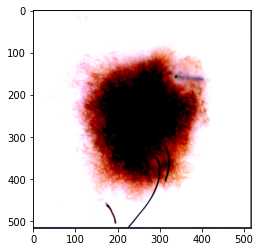

In [0]:
import matplotlib.pyplot as plt
img = val_data[5][0].permute(1, 2, 0).numpy()
plt.imshow(img)

In [0]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super(CNNNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [0]:
simplenet = CNNNet()

In [0]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print('Using GPU')
else:
    device = torch.device("cpu")
    print('Using CPU')

simplenet.to(device)

Using GPU


CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4)

In [0]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [0]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=15, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0, Training Loss: 2.58, Validation Loss: 0.51, accuracy = 0.80
Epoch: 1, Training Loss: 0.52, Validation Loss: 0.53, accuracy = 0.80
Epoch: 2, Training Loss: 0.53, Validation Loss: 0.49, accuracy = 0.80
Epoch: 3, Training Loss: 0.51, Validation Loss: 0.56, accuracy = 0.79
Epoch: 4, Training Loss: 0.50, Validation Loss: 0.50, accuracy = 0.80
Epoch: 5, Training Loss: 0.46, Validation Loss: 0.49, accuracy = 0.79
Epoch: 6, Training Loss: 0.45, Validation Loss: 0.51, accuracy = 0.79
Epoch: 7, Training Loss: 0.45, Validation Loss: 0.49, accuracy = 0.80
Epoch: 8, Training Loss: 0.46, Validation Loss: 0.80, accuracy = 0.80
Epoch: 9, Training Loss: 0.48, Validation Loss: 0.53, accuracy = 0.79
Epoch: 10, Training Loss: 0.46, Validation Loss: 0.50, accuracy = 0.78
Epoch: 11, Training Loss: 0.46, Validation Loss: 0.62, accuracy = 0.78
Epoch: 12, Training Loss: 0.45, Validation Loss: 0.50, accuracy = 0.78
Epoch: 13, Training Loss: 0.45, Validation Loss: 0.52, accuracy = 0.79
Epoch: 14, Train

In [0]:
model = simplenet
num_correct = 0 
num_examples = 0
valid_loss = 0.0
loss_fn = torch.nn.CrossEntropyLoss()

for batch in test_data_loader:
  inputs, targets = batch
  inputs = inputs.to(device)
  output = model(inputs)
  print('output')
  print(torch.max(F.softmax(output), dim=1)[1])
  print('targets')
  print(targets)
  targets = targets.to(device)
  loss = loss_fn(output,targets) 
  valid_loss += loss.data.item() * inputs.size(0)
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
  num_correct += torch.sum(correct).item()
  num_examples += correct.shape[0]
valid_loss /= len(test_data_loader.dataset)

output
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
targets
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


output
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
targets
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
output
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
targets
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0])


In [0]:
print('Test loss: ' + str(valid_loss) + ' Accuracy: ' + str(num_correct / num_examples))

Test loss: 0.43710393007372467 Accuracy: 0.8169014084507042
